In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
# load the already done pca on the dataset
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.shape

In [3]:
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix,roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score,plot_roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Exploratory Data Analysis

In [ ]:
data.info()


In [ ]:
# checking for NAN values
data.isnull().values.any()

In [ ]:
# plot bar graph showing the distribution of anmomolous to non-anomolous transactions
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes
# got  - 492 fraud trnasactions

In [ ]:
names = ["Normal","Fraud"]
values = count_classes
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(names,values)

In [ ]:
# separating the fraud and normal data
normal = data[data['Class']==0]
fraud = data[data['Class']==1]
print(normal.shape)
print(fraud.shape)

In [ ]:
# Amount per transaction distrbution
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 30
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

In [ ]:
# time of trnasaction vs amount by class
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

From the second plot, we can observe that fraudulent transactions occur at the same time as normal transaction, making time an irrelevant factor. From the first plot, we can see that most of the fraudulent transactions are small amount transactions. This is however not a huge differentiating feature since majority of normal transactions are also small amount transactions.

In [ ]:
data.hist(figsize=(15,15), bins = 64)
plt.show()

In [4]:
#data.drop(['Time', 'V1', 'V24'], axis=1, inplace=True)
data.drop(['Time', 'V24'], axis=1, inplace=True)

In [6]:
# lets reduce our dataset to say 30% as it is a huge dataset with more than 284k+ objects
df= data.sample(frac = 0.2,random_state=1)
df.shape

(56961, 29)

In [ ]:
data.shape
# you see the difference , original data had 284k examples while the reduced have 85k

In [7]:
# now lets see the distribution again of normal vs fraud transaction
Fraud = df[df['Class']==1]
Normal = df[df['Class']==0]
print(Fraud.shape,Normal.shape)
# you see about 135 fraud cases now

(87, 29) (56874, 29)


We have just 0.16% fraudulent transactions in the dataset. This means that a random guess by the model should yield 0.16% accuracy for fraudulent transactions

In [ ]:
outlier_fraction = len(Fraud)/float(len(Normal))
outlier_fraction 

In [ ]:
#Correlation using heatmap
import seaborn as sns
#get correlations of each features in dataset
corrmat =df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Building Models and Model Prediction

In [8]:
#Create independent and Dependent Features
columns = df.columns.tolist()  # all columns
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]   # removing "Class" from our columns list
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(56961, 28)
(56961,)


In [9]:
# Train_test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
print(y_test)

## Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

## Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [ ]:
n_outliers = len(Fraud)
n_outliers

In [ ]:
#plotting roc curve
def plot_roc(y_test,preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Local Outlier factor

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski',p=2, metric_params=None, contamination=outlier_fraction)
y_train_pred = clf.fit_predict(X_train)
#print(y_pred)
scores_prediction = clf.negative_outlier_factor_
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

# on test data
y_test_pred = clf.fit_predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [33]:
import itertools
classes = np.array(['0','1'])
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])


In [ ]:
print('Total fraudulent transactions detected in training set: ' + str(cm_train[1][1]) + ' / ' + str(cm_train[1][1]+cm_train[1][0]))
print('Total non-fraudulent transactions detected in training set: ' + str(cm_train[0][0]) + ' / ' + str(cm_train[0][1]+cm_train[0][0]))

print('Probability to detect a fraudulent transaction in the training set: ' + str(cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])))
print('Probability to detect a non-fraudulent transaction in the training set: ' + str(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])))

print("Accuracy of unsupervised anomaly detection model on the training set: "+str(100*(cm_train[0][0]+cm_train[1][1]) / (sum(cm_train[0]) + sum(cm_train[1]))) + "%")

In [ ]:
cm_test = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in test set: ' + str(cm_test[1][1]) + ' / ' + str(cm_test[1][1]+cm_test[1][0]))
print('Total non-fraudulent transactions detected in test set: ' + str(cm_test[0][0]) + ' / ' + str(cm_test[0][1]+cm_test[0][0]))

print('Probability to detect a fraudulent transaction in the test set: ' + str(cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])))
print('Probability to detect a non-fraudulent transaction in the test set: ' + str(cm_test[0][0]/(cm_test[0][1]+cm_test[0][0])))

print("Accuracy of unsupervised anomaly detection model on the test set: "+str(100*(cm_test[0][0]+cm_test[1][1]) / (sum(cm_test[0]) + sum(cm_test[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_test_pred)))

In [ ]:
print(classification_report(y_test,y_test_pred))

In [ ]:
#plot_roc_curve(clf,X_test,y_test_pred)

## Isolation Forest

In [ ]:
clf = IsolationForest(n_estimators=100, max_samples=len(X),contamination=outlier_fraction,random_state=state, verbose=0)
clf.fit(X_train)
#scores_prediction = clf.decision_function(X)
y_train_pred = clf.predict(X_train)
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

# On test set
y_test_pred = clf.fit_predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in training set: ' + str(cm_train[1][1]) + ' / ' + str(cm_train[1][1]+cm_train[1][0]))
print('Total non-fraudulent transactions detected in training set: ' + str(cm_train[0][0]) + ' / ' + str(cm_train[0][1]+cm_train[0][0]))

print('Probability to detect a fraudulent transaction in the training set: ' + str(cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])))
print('Probability to detect a non-fraudulent transaction in the training set: ' + str(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])))

print("Accuracy of unsupervised anomaly detection model on the training set: "+str(100*(cm_train[0][0]+cm_train[1][1]) / (sum(cm_train[0]) + sum(cm_train[1]))) + "%")

In [ ]:
cm_test = confusion_matrix( y_test,y_test_pred)
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in test set: ' + str(cm_test[1][1]) + ' / ' + str(cm_test[1][1]+cm_test[1][0]))
print('Total non-fraudulent transactions detected in test set: ' + str(cm_test[0][0]) + ' / ' + str(cm_test[0][1]+cm_test[0][0]))

print('Probability to detect a fraudulent transaction in the test set: ' + str(cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])))
print('Probability to detect a non-fraudulent transaction in the test set: ' + str(cm_test[0][0]/(cm_test[0][1]+cm_test[0][0])))

print("Accuracy of unsupervised anomaly detection model on the test set: "+str(100*(cm_test[0][0]+cm_test[1][1]) / (sum(cm_test[0]) + sum(cm_test[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_test_pred)))

In [ ]:
print(classification_report(y_test,y_test_pred))

In [ ]:
y_pred = clf.decision_function(X_test)

from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))

In [ ]:
plot_roc(y_test,y_pred)

The results we've got through this model are far from ideal. We have not been able to classify fraudulent transactions efficiently despite having a high accuracy (which is not a good metric to measure performance on a skewed dataset anyways). Supervised learning for anomaly detection is the move fot this dataset since we have the labels. One reason why unsupervised learning did not perform well enough is because most of the fraudulent transactions did not have much unusual characteristics regarding them which can be well separated from normal transactions and I feel that's the main reason they provided us with a labelled dataset. Anyways, this notebook represents how unsupervised learning captures anomalies. The accuracy of detecting anomalies on the test set is 25%, which is way better than a random guess (the fraction of anomalies in the dataset is < 0.1%). I have also implemented the supervised learning model for this dataset, which works extremely well.

## Supervised SVM

In [ ]:
from sklearn import preprocessing, svm
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train)

In [ ]:
predictions = classifier.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [ ]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Logistic Regression model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
plot_roc_curve(classifier,X_test,y_test)

## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [39]:
predictions = classifier.predict(X_test)

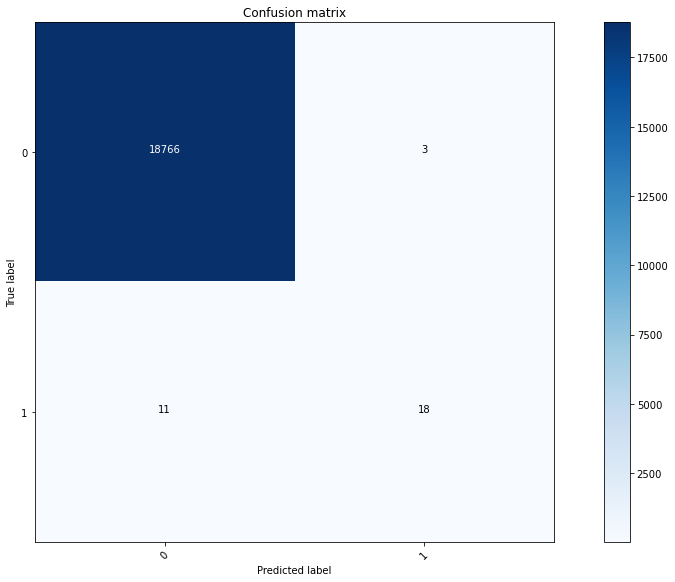

In [40]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [41]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Logistic Regression model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 18 / 29
Total non-fraudulent transactions detected: 18766 / 18769
Probability to detect a fraudulent transaction: 0.6206896551724138
Probability to detect a non-fraudulent transaction: 0.9998401619692046
Accuracy of the Logistic Regression model : 99.92552399191403%
ROC_AUC_score : 0.810265


In [42]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18769
           1       0.86      0.62      0.72        29

    accuracy                           1.00     18798
   macro avg       0.93      0.81      0.86     18798
weighted avg       1.00      1.00      1.00     18798



In [ ]:
plot_roc_curve(classifier,X_test,y_test)

## One Class SVM

In [ ]:
clf = OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, max_iter=-1)
clf.fit(X_train)
#scores_prediction = clf.decision_function(X)
y_train_pred = clf.predict(X_train)
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

# On test set
y_test_pred = clf.fit_predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in training set: ' + str(cm_train[1][1]) + ' / ' + str(cm_train[1][1]+cm_train[1][0]))
print('Total non-fraudulent transactions detected in training set: ' + str(cm_train[0][0]) + ' / ' + str(cm_train[0][1]+cm_train[0][0]))

print('Probability to detect a fraudulent transaction in the training set: ' + str(cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])))
print('Probability to detect a non-fraudulent transaction in the training set: ' + str(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])))

print("Accuracy of unsupervised anomaly detection model on the training set: "+str(100*(cm_train[0][0]+cm_train[1][1]) / (sum(cm_train[0]) + sum(cm_train[1]))) + "%")


In [ ]:
cm_test = confusion_matrix(y_test,y_test_pred )
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in test set: ' + str(cm_test[1][1]) + ' / ' + str(cm_test[1][1]+cm_test[1][0]))
print('Total non-fraudulent transactions detected in test set: ' + str(cm_test[0][0]) + ' / ' + str(cm_test[0][1]+cm_test[0][0]))

print('Probability to detect a fraudulent transaction in the test set: ' + str(cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])))
print('Probability to detect a non-fraudulent transaction in the test set: ' + str(cm_test[0][0]/(cm_test[0][1]+cm_test[0][0])))

print("Accuracy of unsupervised anomaly detection model on the test set: "+str(100*(cm_test[0][0]+cm_test[1][1]) / (sum(cm_test[0]) + sum(cm_test[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_test_pred)))

In [ ]:
print(classification_report(y_test,y_test_pred))

One class SVM doesnt work well because it works on decison spearating bpundary

In [ ]:
#plot_roc_curve(clf,X_test,y_test)

## Multivariate Gaussian Anomaly detection

In [ ]:
def covariance_matrix(X):
    m, n = X.shape 
    tmp_mat = np.zeros((n, n))
    mu = X.mean(axis=0)
    for i in range(m):
        tmp_mat += np.outer(X[i] - mu, X[i] - mu)
    return tmp_mat / m

In [ ]:
y_test

In [ ]:
cov_mat = covariance_matrix(np.array(X_train))
cov_mat

In [ ]:
cov_mat_inv = np.linalg.pinv(cov_mat)
cov_mat_det = np.linalg.det(cov_mat)
def multi_gauss(x):
    n = len(cov_mat)
    #print(x)
    return (np.exp(-0.5 * np.dot(x, np.dot(cov_mat_inv, x.transpose()))) 
            / (2. * np.pi)**(n/2.) 
            / np.sqrt(cov_mat_det))

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test

In [ ]:
from sklearn.metrics import confusion_matrix

def stats(X_test, y_test, eps):
    predictions = np.array([multi_gauss(x) <= eps for x in X_test], dtype=bool)
    #print("fk")
    y_test = np.array(y_test, dtype=bool)
    #print("fk")
    #print(y_test)
    #print(predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    #print("fk")
    recall = tp / (tp + fn)
    prec = tp / (tp + fp)
    F1 = 2 * recall * prec / (recall + prec)
    return recall, prec, F1

In [ ]:
eps = 0.000000000002

In [ ]:
#print(y_test)
recall, prec, F1 = stats(X_test, y_test, eps)
print("For a boundary of:", eps)
print("Recall:", recall)
print("Precision:", prec)
print("F1-score:", F1)

In [ ]:
validation = []
print(X_test)
print(y_test)
for thresh in np.array([1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]) * eps:
    recall, prec, F1 = stats(X_test, y_test, thresh)
    validation.append([thresh, recall, prec, F1])

In [ ]:
x = np.array(validation)[:, 0]
y1 = np.array(validation)[:, 1]
y2 = np.array(validation)[:, 2]
y3 = np.array(validation)[:, 3]
plt.plot(x, y1)
plt.title("Recall")
plt.xscale('log')
plt.show()
plt.plot(x, y2)
plt.title("Precision")
plt.xscale('log')
plt.show()
plt.plot(x, y3)
plt.title("F1 score")
plt.xscale('log')
plt.show()

## Classification Using Neural Networks

In [12]:
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [15]:
X_train.shape

(38163, 28)

In [63]:
# Building our model with 2 hidden layers
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=20, batch_size=10)


Epoch 1/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.0730 - accuracy: 0.9984
Epoch 2/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.0172 - accuracy: 0.9987
Epoch 3/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.0188 - accuracy: 0.9989
Epoch 4/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.0146 - accuracy: 0.9988
Epoch 5/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.0111 - accuracy: 0.9989
Epoch 6/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.0120 - accuracy: 0.9990
Epoch 7/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.0089 - accuracy: 0.9989
Epoch 8/20
3817/3817 [==============================] - 5s 1ms/step - loss: 0.0106 - accuracy: 0.9991
Epoch 9/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.0066 - accuracy: 0.9991
Epoch 10/20
3817/3817 [==============================] - 4s 1ms/step - loss: 0.006

In [57]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

588/588 [==============================] - 1s 896us/step - loss: 0.0027 - accuracy: 0.9994
Accuracy: 99.94


In [58]:
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
rounded = [round(x[0]) for x in predictions]
rounded = np.array(rounded)
rounded.shape

(18798,)

In [59]:
# make class predictions with the model
predictions = model.predict_classes(X_test)
predictions.shape

(18798, 1)

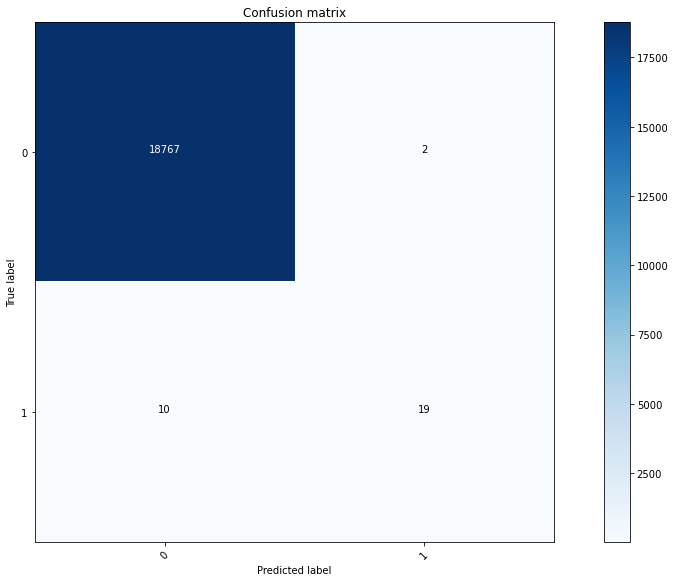

In [60]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [61]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Neural Network model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 19 / 29
Total non-fraudulent transactions detected: 18767 / 18769
Probability to detect a fraudulent transaction: 0.6551724137931034
Probability to detect a non-fraudulent transaction: 0.999893441312803
Accuracy of the Neural Network model : 99.9361634216406%
ROC_AUC_score : 0.827533


In [62]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18769
           1       0.90      0.66      0.76        29

    accuracy                           1.00     18798
   macro avg       0.95      0.83      0.88     18798
weighted avg       1.00      1.00      1.00     18798

